In [1]:
import joblib
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv("../data/Placement_Data_Full_Class.csv")
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB


The dataset is downloaded from [Campus Recruitment Dataset](https://www.kaggle.com/benroshan/factors-affecting-campus-placement) on Kaggle. It consists of placement data of students in a XYZ campus. From above data overview and short summary, there're 15 columns in total:

- `sl_no`: serial number
- `gender`: students gender (Male or Female) 
- `ssc_p`: secondary eduacation percentage (10th grade)
- `ssc_b`: board of education, central or others
- `hsc_p`: higher education percentage (12th grade)
- `hsc_b`: board of education, central or others
- `hsc_s`: specialization in higher education
- `degree_p`: degree of percentage
- `degree_t`: undergraduate/degree type, field of degree education
- `workex`: work experience
- `etest_p`: employability test percentage, conducted by college
- `specialisation`: post graduation (MBA) specialization
- `mba_p`: MBA percentage
- `status`: status of placement, placed or not placed
- `salary`: salary offered by corporate to candidates

**First, since `sl_no` only act as identifier, we can drop it and use the dataframe index as our new identifier.**

> Remember only run the cell below once since it modifies the original data. If the cell is accidently ran more than one, just reload it again.

In [4]:
df = df.drop(columns="sl_no")
df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


By inspecting previous short summary, we know the dataset is composed of some categorical and numerical features. To ease our analysis and modeling later, **let's define define variables that represents those categorical and numerical feature names.**

In [5]:
categorical_cols = ["gender", "ssc_b", "hsc_b", "hsc_p", "degree_t", "workex", "specialisation"]
numerical_cols = ["ssc_p", "hsc_p", "degree_p", "etest_p", "mba_p", "salary"]

Again, looking at the short summary above, column `salary` has some missing values in it. In fact, it's the only column who has missing values. Let's take a look at it first.

In [6]:
print("Num of missing values in salary column:", len(df[df["salary"].isna()]))
df[df["salary"].isna()]

Num of missing values in salary column: 67


,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
3,M,56.0,Central,52.0,Central,Science,52.00,Sci&Tech,No,66.00,Mkt&HR,59.43,Not Placed,NaN
5,M,55.0,Others,49.8,Others,Science,67.25,Sci&Tech,Yes,55.00,Mkt&Fin,51.58,Not Placed,NaN
6,F,46.0,Others,49.2,Others,Commerce,79.00,Comm&Mgmt,No,74.28,Mkt&Fin,53.29,Not Placed,NaN
9,M,58.0,Central,70.0,Central,Commerce,61.00,Comm&Mgmt,No,54.00,Mkt&Fin,52.21,Not Placed,NaN
12,F,47.0,Central,55.0,Others,Science,65.00,Comm&Mgmt,No,62.00,Mkt&HR,65.04,Not Placed,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,F,67.0,Central,70.0,Central,Commerce,65.00,Others,No,88.00,Mkt&HR,71.96,Not Placed,NaN
201,M,54.2,Central,63.0,Others,Science,58.00,Comm&Mgmt,No,79.00,Mkt&HR,58.44,Not Placed,NaN
206,M,41.0,Central,42.0,Central,Science,60.00,Comm&Mgmt,No,97.00,Mkt&Fin,53.39,Not Placed,NaN
208,F,43.0,Central,60.0,Others,Science,65.00,Comm&Mgmt,No,92.66,Mkt&HR,62.92,Not Placed,NaN


In [7]:
df[["salary"]].describe()

,salary
count,148.000000
mean,288655.405405
std,93457.452420
min,200000.000000
25%,240000.000000
50%,265000.000000
75%,300000.000000
max,940000.000000


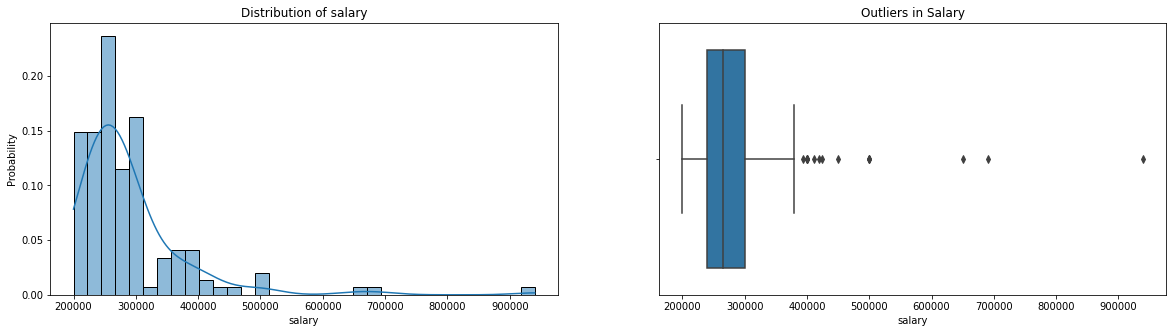

In [8]:
plt.figure(figsize=(20, 5))

plt.subplot(121)
sns.histplot(data=df, x="salary", stat="probability", kde=True)
plt.title("Distribution of salary")

plt.subplot(122)
sns.boxplot(data=df, x="salary")
plt.title("Outliers in Salary")

plt.show()

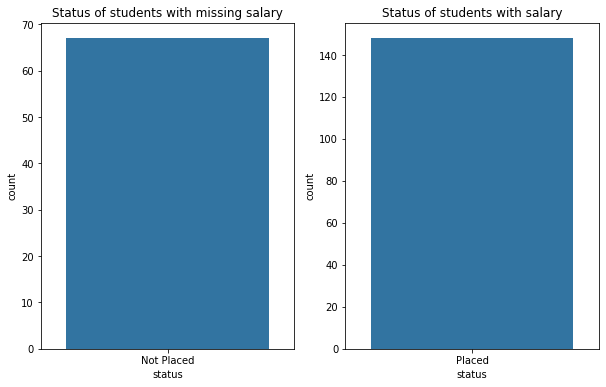

In [9]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
sns.countplot(data=df[df["salary"].isna()], x="status")
plt.title("Status of students with missing salary")

plt.subplot(122)
sns.countplot(data=df[~df["salary"].isna()], x="status")
plt.title("Status of students with salary")
plt.show()

The above visualizations shows that `salary` is positively skewed and has some outliers. Furthermore, if we compare the `status` between those who have salary and who don't have (missing) salary, it tells us that all of the students with missing salary are not placed. Hence, they don't have any salary. So, we can fill the missing salary with value `0`.

In [10]:
df["salary"] = df["salary"].fillna(value=0)

In [11]:
df.info()
df[["salary"]].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          215 non-null    object 
 1   ssc_p           215 non-null    float64
 2   ssc_b           215 non-null    object 
 3   hsc_p           215 non-null    float64
 4   hsc_b           215 non-null    object 
 5   hsc_s           215 non-null    object 
 6   degree_p        215 non-null    float64
 7   degree_t        215 non-null    object 
 8   workex          215 non-null    object 
 9   etest_p         215 non-null    float64
 10  specialisation  215 non-null    object 
 11  mba_p           215 non-null    float64
 12  status          215 non-null    object 
 13  salary          215 non-null    float64
dtypes: float64(6), object(8)
memory usage: 23.6+ KB


,salary
count,215.000000
mean,198702.325581
std,154780.926716
min,0.000000
25%,0.000000
50%,240000.000000
75%,282500.000000
max,940000.000000


## Exploratory Data Analysis

In [12]:
df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,0.0
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


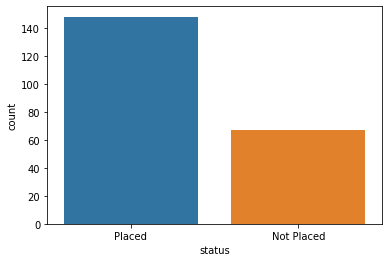

In [13]:
sns.countplot(data=df, x="status")
plt.show()

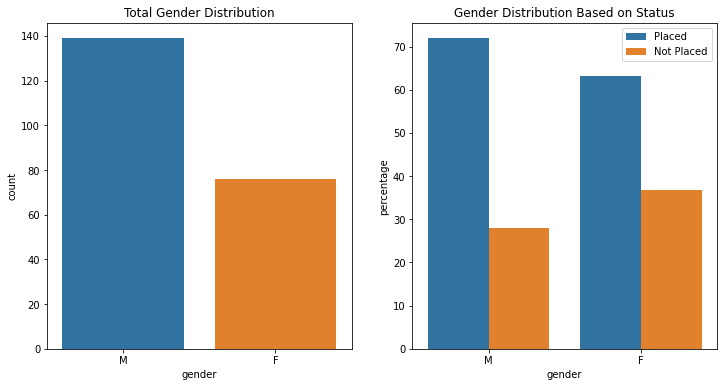

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.countplot(
    data=df,
    x="gender"
)
plt.title("Total Gender Distribution")

plt.subplot(122)
sns.barplot(
    data=df.groupby("gender")["status"].value_counts(normalize=True).mul(100).rename("percentage").reset_index(),
    x="gender", y="percentage", hue="status", hue_order=["Placed", "Not Placed"], order=["M", "F"]
)
plt.title("Gender Distribution Based on Status")
plt.legend(loc="best")
plt.show()

**Remarks**

- The dataset consists of more male than female students, about ~140 to ~75
- Based on the `status`, it looks like male students are more likely to be placed than female students

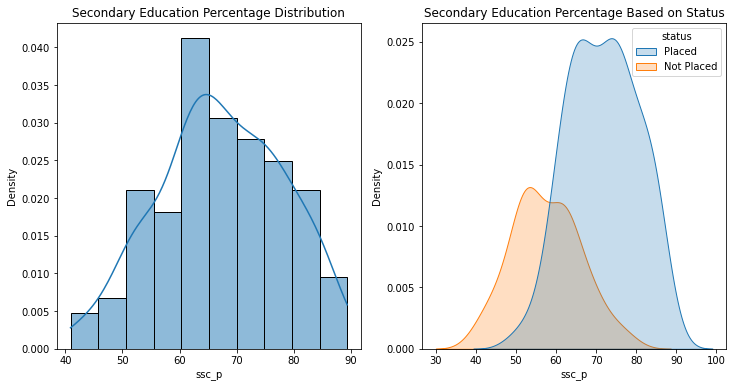

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.histplot(data=df, x="ssc_p", kde=True, stat="density")
plt.title("Secondary Education Percentage Distribution")

plt.subplot(122)
sns.kdeplot(data=df, x="ssc_p", hue="status", fill=True)
plt.title("Secondary Education Percentage Based on Status")
plt.show()

<Figure size 864x432 with 0 Axes>

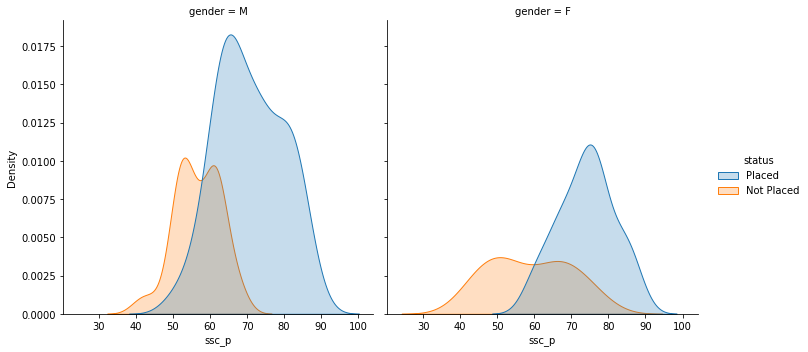

In [16]:
plt.figure(figsize=(12, 6))
sns.displot(data=df, x="ssc_p", hue="status", kind="kde", fill=True, col="gender")
plt.show()

**Remarks**

- In general, to be **absolutely accepted (placed)**, students need to achieve secondary education percentage **>90**
- Conversely, students who have secondary education percentage **<40** would **fail** and are not placed
- There is a different interval for male and female students based on their secondary education percentage. For male students, they only need to have `ssc_p` value **more than 80** to be absolutely accepted, whereas female students need to have **more than 90**. Also, almost all female students who have `ssc_p` values **under 50** are not placed compare to male students.

> Since our objective is not doing deep exploratory, we can stop our exploratory now. Next, let's start choose some features, preprocess it, and feed it to our models.

## Data Preprocessing

In [17]:
features = ["ssc_p", "hsc_p", "degree_p", "etest_p"]
target = ["status"]

In [18]:
X = df[features].values
y = df[target].values.flatten()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)
label_to_name = {idx: name for idx, name in enumerate(encoder.classes_)}
print("Targets:", label_to_name)

X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y_enc, test_size=.3, stratify=y, random_state=11)
print("Training size:", X_train.shape[0])
print("Validation size:", X_valid.shape[0])

Targets: {0: 'Not Placed', 1: 'Placed'}
Training size: 150
Validation size: 65


## Modelling

In [19]:
logistic = LogisticRegression()
knn = KNeighborsClassifier()
nb = GaussianNB()
d_tree = DecisionTreeClassifier()

for model in [logistic, knn, nb, d_tree]:
    print(f"\n--- Using {model.__class__.__name__} ---")
    start = time()
    model.fit(X_train, y_train)
    end = time()
    print(f"Done training model in {end - start:.3f}s..")
    start = time()
    prediction = model.predict(X_train)
    end = time()
    print(f"Done inferencing in {end - start:.3f}s..")
    print("performance on training set:")
    print(classification_report(y_train, prediction, target_names=encoder.classes_))
    print("performance on validation set:")
    print(classification_report(y_valid, model.predict(X_valid), target_names=encoder.classes_))


--- Using LogisticRegression ---
Done training model in 0.038s..
Done inferencing in 0.000s..
performance on training set:
              precision    recall  f1-score   support

  Not Placed       0.78      0.60      0.67        47
      Placed       0.83      0.92      0.88       103

    accuracy                           0.82       150
   macro avg       0.81      0.76      0.78       150
weighted avg       0.82      0.82      0.81       150

performance on validation set:
              precision    recall  f1-score   support

  Not Placed       0.82      0.70      0.76        20
      Placed       0.88      0.93      0.90        45

    accuracy                           0.86        65
   macro avg       0.85      0.82      0.83        65
weighted avg       0.86      0.86      0.86        65


--- Using KNeighborsClassifier ---
Done training model in 0.061s..
Done inferencing in 0.035s..
performance on training set:
              precision    recall  f1-score   support

  Not Plac

Considering models who don't overfit the training set (which means excluding Decision Tree) and looking at the performance on the validation set, there are two strong candidates:

* Logistic Regression model
* Gaussian Naive Bayes

Both candidates have the shortest training and inference time. The last thing to consider is the overall accuracy and f1-score on both training and validation set. **The winner is Gaussian Naive Bayes with overall accuracy 88% and f1-scores of 79% and 91% for False and True, consecutively**.

## Make Model Pipeline

In [20]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("naive_bayes", GaussianNB())
])
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Done training model in {end - start:.3f}s..")
start = time()
prediction = model.predict(X_train)
end = time()
print(f"Done inferencing in {end - start:.3f}s..")
print("performance on training set:")
print(classification_report(y_train, prediction, target_names=encoder.classes_))
print("performance on validation set:")
print(classification_report(y_valid, model.predict(X_valid), target_names=encoder.classes_))

Done training model in 0.011s..
Done inferencing in 0.001s..
performance on training set:
              precision    recall  f1-score   support

  Not Placed       0.76      0.72      0.74        47
      Placed       0.88      0.89      0.88       103

    accuracy                           0.84       150
   macro avg       0.82      0.81      0.81       150
weighted avg       0.84      0.84      0.84       150

performance on validation set:
              precision    recall  f1-score   support

  Not Placed       0.83      0.75      0.79        20
      Placed       0.89      0.93      0.91        45

    accuracy                           0.88        65
   macro avg       0.86      0.84      0.85        65
weighted avg       0.88      0.88      0.88        65



In [21]:
filename = "../models/gaussiannb.joblib"
joblib.dump(model, filename)

['../models/gaussiannb.joblib']

In [22]:
loaded_model = joblib.load(filename)
print("performance on validation set:")
print(classification_report(y_valid, model.predict(X_valid), target_names=encoder.classes_))

performance on validation set:
              precision    recall  f1-score   support

  Not Placed       0.83      0.75      0.79        20
      Placed       0.89      0.93      0.91        45

    accuracy                           0.88        65
   macro avg       0.86      0.84      0.85        65
weighted avg       0.88      0.88      0.88        65



In [34]:
for output in model.predict(np.array([0, 0, 0, 0]).reshape(1, -1)):
    if output == 1:
        print("Placed")
    else:
        print("Not placed")

Placed
